In [3]:
import numpy as np 
import pandas as pd 
import seaborn as sns

data = pd.read_csv("/content/sample_data/weatherAUS.csv")

#Vérifications
#print(data.info())
data[0:5]

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,NW,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


Nous allons ici nou débarasser des valeur nulles et des colonnes qui nous ne servirons pas dans notre analyse

In [4]:
data = data.drop(columns=['Location','Date','Evaporation','Sunshine','Cloud3pm','Cloud9am'],axis=1)

Replacement des valeurs catégorielles par des nombres et suppression des valeurs nulles

In [5]:
data['RainToday'].replace({'No': 0, 'Yes': 1},inplace = True)
data['RainTomorrow'].replace({'No': 0, 'Yes': 1},inplace = True)

#suppression des valeurs nulles
data.dropna(axis=0, how='any', thresh=None, subset=None, inplace=True)
print(data.shape)

#Numerisons les colonnes catégorielles
categorical_columns = ['WindGustDir', 'WindDir3pm', 'WindDir9am']
data = pd.get_dummies(data, columns=categorical_columns)
print(data.shape)

(112925, 17)
(112925, 62)


#Nettoyage de notre dataset

In [6]:
from sklearn import preprocessing
from scipy.stats import zscore

numeric_cols = data.select_dtypes(include=[np.number]).columns
data[numeric_cols].apply(zscore)

#Mise à l'echelle de la data..
data = data.astype('float64')
scaler = preprocessing.MinMaxScaler()
scaler.fit(data)
data = pd.DataFrame(scaler.transform(data), index=data.index, columns=data.columns)

#Séparation de nos features..
X = data.loc[:,data.columns!='RainTomorrow']
y = data['RainTomorrow']

Maintenant selectionnons les meilleures colonnes pour notre KNN et séparons les données pour les entrainer et tester

In [7]:
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import train_test_split

selector = SelectKBest(chi2, k=4)
selector.fit_transform(X, y)
print(X.columns[selector.get_support(indices=True)])


X = data[X.columns[selector.get_support(indices=True)]]

#séparation des données
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=1)

Index(['Rainfall', 'Humidity9am', 'Humidity3pm', 'RainToday'], dtype='object')


Distribution des données

0.0    87906
1.0    25019
Name: RainTomorrow, dtype: int64


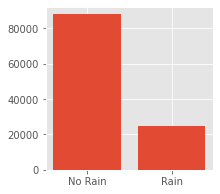

In [8]:
import matplotlib.pyplot as plt
import matplotlib.style as sty

sty.use('ggplot')
plt.figure(figsize=(3,3))
plt.hist(y,bins=2,rwidth=0.8)
plt.xticks([0.25,0.75],['No Rain','Rain'])

print(y.value_counts())

Essayons avec tous ces valeurs 

In [9]:
# KNN
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors = 20)
knn.fit(x_train,y_train.values.ravel())
y_pred_KNN = knn.predict(x_test)
print(" {} nn score: {} ".format(20,knn.score(x_test,y_test)))

 20 nn score: 0.8316311470570872 


Matrice de confusion

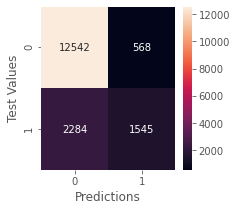

In [10]:
from sklearn.metrics import confusion_matrix

confMatKnn = confusion_matrix(y_test,y_pred_KNN)

f, ax = plt.subplots(figsize = (3,3))
sns.heatmap(confMatKnn,annot=True,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("Predictions")
plt.ylabel("Test Values")
plt.show()

Détermination du meilleur n_neighbors pour le KNN

In [11]:
#Cela peut prendre du temps
r = range(15,20)
for i in r:
   knn = KNeighborsClassifier(n_neighbors = i)
   knn.fit(x_train,y_train.values.ravel())
   #prediction = knn.predict(x_test)
   print(" {} nn score: {} ".format(i,knn.score(x_test,y_test)))    

 15 nn score: 0.8299191215538108 
 16 nn score: 0.8313359702461774 
 17 nn score: 0.8305094751756302 
 18 nn score: 0.8313950056083594 
 19 nn score: 0.8325757128519984 


Arbre de décision

In [12]:
from sklearn.tree import DecisionTreeClassifier

dtClassifier = DecisionTreeClassifier()
dtClassifier.fit(x_train,y_train)
y_pred_DT = dtClassifier.predict(x_test)
print("Score de l'arbre de décision: " , dtClassifier.score(x_test,y_test))

Score de l'arbre de décision:  0.8005195111872011


Visualisation de la matrice de confusion de l'abre 

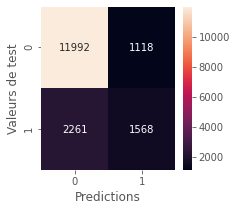

In [13]:
confMatDT = confusion_matrix(y_test,y_pred_DT)

f, ax = plt.subplots(figsize = (3,3))
sns.heatmap(confMatDT,annot=True,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("Predictions")
plt.ylabel("Valeurs de test")
plt.show()

Le Random Forest

In [14]:
from sklearn.ensemble import RandomForestClassifier

rfClassifier = RandomForestClassifier(n_estimators = 20,random_state = 1)
rfClassifier.fit(x_train,y_train.values.ravel())
y_pred_RF = rfClassifier.predict(x_test)
print("Score du classifier Random Forest: " , dtClassifier.score(x_test,y_test))

Score du classifier Random Forest:  0.8005195111872011


Visualisation de la matrice de confusion pour le Random Forest

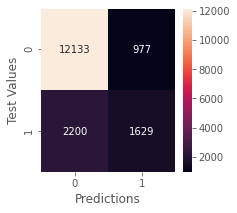

In [15]:
confMatRF = confusion_matrix(y_test,y_pred_RF)

f, ax = plt.subplots(figsize = (3,3))
sns.heatmap(confMatRF,annot=True,fmt=".0f",ax=ax)
plt.xlabel("Predictions")
plt.ylabel("Test Values")
plt.show()